In [194]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as sps

## Utility Functions

In [195]:
def convm(x, p):
    '''Convolution Matrix
    (N + p - 1) by p non-symmetric Toeplitz matrix
    '''

    if p < 1:
        raise ValueError(f"p must be greater or equal to 1.")

    N = len(x) + 2 * p - 2
    # the signal centered over its support
    # needed for the signal information-preserving frequency spectrum
    xcol = (x.copy()).reshape(-1, 1)
    xpad = np.concatenate((np.zeros((p-1, 1)), xcol, np.zeros((p-1, 1))))
    X = np.empty([len(x) + p - 1, p])
    for i in range(p):
        X[:, i] = xpad[p - i - 1:N - i,0]
    return X

def covar(x, p):
    '''Covariance Matrix
    p x p hermitian toeplitz matrix of sample covariances
    '''

    m = len(x)
    # remove the mean
    x0 = x.copy() - np.mean(x)
    R = np.transpose((convm(x0, p + 1).conjugate())) @ (convm(x0, p + 1) / (m - 1))
    return R

def back_substitution(x, p):
    '''Convinient recursion for an all-pole model.'''
    pass


In [196]:
x = np.array([1, 3, 2])
p = 4
X = convm(x, p)
print(X.shape)
print(X)
print(f"{x=}")
R = covar(x, p)
print(R.shape)
print(R)

(6, 4)
[[1. 0. 0. 0.]
 [3. 1. 0. 0.]
 [2. 3. 1. 0.]
 [0. 2. 3. 1.]
 [0. 0. 2. 3.]
 [0. 0. 0. 2.]]
x=array([1, 3, 2])
(5, 5)
[[ 1.  -0.5  0.   0.   0. ]
 [-0.5  1.  -0.5  0.   0. ]
 [ 0.  -0.5  1.  -0.5  0. ]
 [ 0.   0.  -0.5  1.  -0.5]
 [ 0.   0.   0.  -0.5  1. ]]


## Determinist Signal Modeling


In [197]:
def pade(x, p, q):
    '''
    Reference Page 138, Table 4.1
    The Pade approximation models a signal as the unis sample response
    of linear shift invariant system have p poles and q zeros.
    '''
    if p + q > len(x):
        raise ValueError(f"Model order {p + q} is too large.")

    X = convm(x, p + 1)

    # Linear difference matrix spanning the number of zeros
    Xq = X[q + 1:q + p + 1, 1:p + 1].copy()
    print(Xq.shape)
    a = np.linalg.solve(-Xq, X[q + 1: q + p + 1, 0])
    # a(0) normalized to 1
    a = np.concatenate((np.ones(1), a)).reshape(-1, 1)
    b = X[:q + 1, :p + 1] @ a

    return (a, b)

In [198]:
x = np.array([1, 1.5, 0.75, 0.375, 0.1875, 0.0938])

x20 = pade(x, 2, 0)
x02 = pade(x, 0, 2)
x11 = pade(x, 1, 1)

print(x20)
print(x02)
print(x11)

(2, 2)
(0, 0)
(1, 1)
(array([[ 1. ],
       [-1.5],
       [ 1.5]]), array([[1.]]))
(array([[1.]]), array([[1.  ],
       [1.5 ],
       [0.75]]))
(array([[ 1. ],
       [-0.5]]), array([[1.],
       [1.]]))


In [199]:
def normal_prony(x, p, q):
    pass

def prony(x, p, q):
    '''
    Least square minimization of poles to get denominator coefficients.
    Solves directly (Pade method) to get numerator coefficients.
    Also calculates minimum error achieved.
    '''

    if p + q > len(x):
        raise ValueError(f"Model order {p + q} is too large.")

    # copy and make given signal column array
    X = convm(x, p + 1)
    print(X.shape)
    M = p + q
    N = len(x)
    print(f"{N=}")
    xc = x.copy().reshape(-1, 1)

    #Xq = X[q + 1:q + p + 1, 1:p + 1].copy()
    #a = np.linalg.solve(-Xq, X[q + 1: q + p + 1, 0])
    #a = np.concatenate((np.ones(1), a)).reshape(-1, 1)
    #b = X[:q + 1, :p + 1] @ a

    # the factorization does not guarantee nonsingularity!
    # resulting matrix is positive *semi*-definite: all zeros are
    # on/inside the unit circle
    Xq = X[q:N + p - 1, :p].copy()
    Xq1 = X[q + 1:N + p, 0].copy()
    Xq_H = Xq.conjugate().transpose()
    rx = Xq_H @ Xq1
    Xinv = np.linalg.inv(Xq_H @ Xq)
    a = -Xinv @ rx
    print(a.shape)
    # a(0) normalized to 1
    a = np.concatenate((np.ones(1), a)).reshape(-1, 1)
    # same as Pade method
    b = X[:q + 1, :p + 1] @ a

    # the minimum squared error
    err = np.transpose(xc[q + 1:N]) @ X[q + 1:N, :p + 1] @ a

    return a, b, err

In [200]:
sig = np.ones(21)
res = prony(sig, 1, 1)
for x in res: print(f"{x=}")

(22, 2)
N=21
(1,)
x=array([[ 1.  ],
       [-0.95]])
x=array([[1.  ],
       [0.05]])
x=array([[0.95]])


In [201]:
# Shannon
# poissons
# autocorrs
# gaussians
# diracs

N = 81
N2 = (N - 1) // 2
#t = np.linspace(-N2, N2, N)
t = np.arange(N) - 5
isys = 0.5 * np.sinc(t / 2)
print(isys[:11].round(4))

res = prony(isys, 5, 5)
print(res[0].round(4))
print(res[1].round(4))

[ 0.0637 -0.     -0.1061  0.      0.3183  0.5     0.3183  0.     -0.1061
 -0.      0.0637]
(86, 6)
N=81
(5,)
[[ 1.    ]
 [-1.9093]
 [ 2.374 ]
 [-1.9531]
 [ 1.035 ]
 [-0.2893]]
[[ 0.0637]
 [-0.1216]
 [ 0.045 ]
 [ 0.0783]
 [ 0.1323]
 [ 0.081 ]]


In [202]:
def shanks(x, p, q):
    '''
    '''

    N = len(x)
    if p + q >= N:
        raise ValueError(f"Model order {p + q} is too large.")

    a, _, _ = prony(x, p, q)
    print(f"{a.transpose().ravel()=}")
    u = np.concatenate((np.ones(1), np.zeros(N - 1)))
    zpk = sps.tf2zpk([1], a.ravel())
    sos = sps.zpk2sos(*zpk)
    res = sps.sosfilt(sos, x=u)
    G = convm(res.ravel(), q + 1)
    G0 = G[:N,].copy()
    print(f"{G0.shape=}")
    G0_H = np.transpose((G0.copy()).conjugate())
    x0 = (x.copy()).reshape(-1, 1)
    gx = G0_H @ x0
    # the factorization does not guarantee nonsingularity!
    # resulting matrix is positive *semi*-definite
    Ginv = np.linalg.inv(G0_H @ G0)
    print(f"{x.shape=}")
    print(f"{Ginv.shape=}")
    b = Ginv @ gx
    err = 1

    return a, b, err

sig = np.ones(21)
a, b, err = shanks(sig, 1, 1)
print(f"{a=}")
print(f"{b=}")
print(f"{err=}")

N = 81
t = np.arange(N) - 5
isys = 0.5 * np.sinc(t / 2)
res = shanks(isys, 5, 5)
print(res)

(22, 2)
N=21
(1,)
a.transpose().ravel()=array([ 1.  , -0.95])
G0.shape=(21, 2)
x.shape=(21,)
Ginv.shape=(2, 2)
a=array([[ 1.  ],
       [-0.95]])
b=array([[1.        ],
       [0.48542157]])
err=1
(86, 6)
N=81
(5,)
a.transpose().ravel()=array([ 1.        , -1.90933949,  2.37404932, -1.95305779,  1.0349931 ,
       -0.28932854])
G0.shape=(81, 6)
x.shape=(81,)
Ginv.shape=(6, 6)
(array([[ 1.        ],
       [-1.90933949],
       [ 2.37404932],
       [-1.95305779],
       [ 1.0349931 ],
       [-0.28932854]]), array([[ 0.06366198],
       [-0.12278121],
       [ 0.04903531],
       [ 0.07290069],
       [ 0.13450599],
       [ 0.08350918]]), 1)


In [203]:
def spike(g, n0, n):
    '''Leaset Squares Inverse Filter'''

    g = g.reshape(-1, 1)
    m = len(g)

    if m + n - 1 <= n0:
        raise ValueError(f"m + n - 1 must be less than {n0=}")

    G = convm(g, n)
    d = np.zeros((m + n - 1, 1))
    d[n0] = 1
    print(f"{d.shape=}, {G.shape=}")
    G_H = np.transpose(G.conjugate())

    print(f"{G_H.shape=}, {G.shape=}")
    Ginv = np.linalg.inv(G_H @ G)
    h = Ginv @ G_H @ d

    return h

[0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091 1.         0.90909091
 0.81818182 0.72727273 0.63636364 0.54545455 0.45454545 0.36363636
 0.27272727 0.18181818 0.09090909]
d.shape=(42, 1), G.shape=(42, 22)
G_H.shape=(22, 42), G.shape=(42, 22)


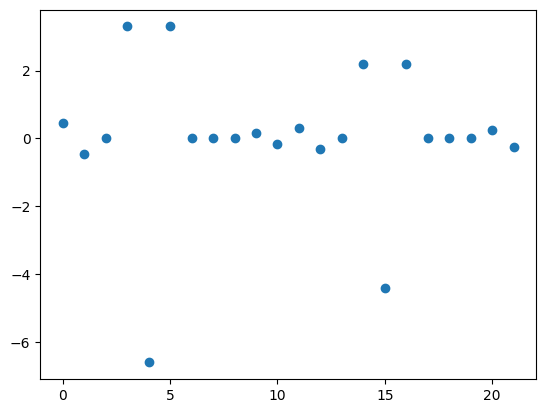

In [204]:
N = 11
ticks = (np.arange(N) + 1) / N
ticks = np.concatenate((ticks, ticks[-2::-1]))
print(ticks)
h = spike(ticks, 3, 22)
plt.plot(h, 'o')

In [205]:

def ipf(x, p, q, n = 10, a = None):
    pass
	

In [206]:
def acm(x, p) -> tuple[np.ndarray, np.ndarray]:
    x0 = x.copy().ravel().reshape(-1, 1)
    N = len(x0)
    if p >= len(x0):
        raise ValueError("p (all-pole model) too large")

    X = convm(x, p + 1)
    Xq = X[:N + p - 1, :p].copy()
    rx = X[1:N + p, 0].copy()
    Xq_H = Xq.copy().conjugate().transpose()
    Xinv = np.linalg.inv(Xq_H @ Xq)
    a1 = -Xinv @ Xq_H @ rx
    a = np.concatenate((np.ones(1), a1)).reshape(-1, 1)
    err = np.abs(X[:N + p, 0].T @ X @ a)

    return a, err

def covm(x, p):
    '''
    Solve the complete Prony normal equations.
    '''
    x0 = x.copy().ravel().reshape(-1, 1)
    N = len(x0)
    if p >= len(x0):
        raise ValueError("p (all-pole model) too large")

    X = convm(x0, p + 1)
    Xq = X[p - 1:N - 1, :p].copy()
    cx = X[p:N, 0].copy()
    Xq_H = Xq.copy().conjugate().transpose()
    print(f"{Xq=}")
    Xinv = np.linalg.inv(Xq_H @ Xq)
    a1 = -Xinv @ Xq_H @ cx
    a = np.concatenate((np.ones(1), a1)).reshape(-1, 1)
    err = np.abs(cx.transpose() @ X[p:N,] @ a)
    return a, err

sig = np.ones(20)
sig[1::2] *= -1
print(sig)
a, err = acm(sig, 2)
print(res)
# b0 is the root of the least squared error - just a gain
b = np.sqrt(err)

try:
    res = covm(sig, 2)
except np.linalg.LinAlgError as exc:
    print("Singular matrix, may indicate that model order can be reduced.")


[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
(array([[ 1.        ],
       [-1.90933949],
       [ 2.37404932],
       [-1.95305779],
       [ 1.0349931 ],
       [-0.28932854]]), array([[ 0.06366198],
       [-0.12278121],
       [ 0.04903531],
       [ 0.07290069],
       [ 0.13450599],
       [ 0.08350918]]), 1)
Xq=array([[-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.]])
Singular matrix, may indicate that model order can be reduced.


## System State Matrices

In [207]:
def pronynormal(x, p, q):
    pass

def ywe(x, p, q):
    pass

def mywe(x, p, q):
    pass

def eywe(x, p, q):
    pass


In [208]:

def durbin(x, p, q):
    x0 = x.copy().ravel().reshape(-1, 1)
    N = len(x0)
    if p >= len(x0):
        raise ValueError("p (all-pole model) too large")

    a, eps = acm(x, p)
    b, eps = acm(a / np.sqrt(eps), q)
    b /= np.sqrt(eps)
    return a, b

sig = np.ones(20)
sig[1::2] *= -1
print(sig)
a, err = durbin(sig, 1, 0)
print(a, err)

[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
[[1.  ]
 [0.95]] [[1.01240661]]


## Levinson Recursion

In [209]:
def rtoa(r) -> tuple[np.ndarray, np.ndarray]:
    '''
    The Levison-Durbin recursion.
    "Recursive mapping from a set of autocorrelations to a set of model parameters."
    '''

    a = np.ones((1, 1))
    epsilon = r[0]
    p = len(r) - 1
    r = r.reshape(-1, 1)

    for j in range(1, p + 1):
        gamma = -np.transpose(r[1:1 + j,]) @ np.flipud(a) / epsilon
        an = np.concatenate((a, np.zeros((1, 1)))).reshape(-1, 1)
        anT = np.conjugate(np.flipud(a))
        a = an + gamma * np.concatenate(([0], anT.ravel())).reshape(-1, 1)
        epsilon = epsilon * (1 - np.abs(gamma)**2)
        print(f"{gamma=},\n{a=},\n{epsilon=}\n")
    return a, epsilon

res = rtoa(np.array([1, 0.5, 0.5, 0.25]))
print(res)

gamma=array([[-0.5]]),
a=array([[ 1. ],
       [-0.5]]),
epsilon=array([[0.75]])

gamma=array([[-0.33333333]]),
a=array([[ 1.        ],
       [-0.33333333],
       [-0.33333333]]),
epsilon=array([[0.66666667]])

gamma=array([[0.125]]),
a=array([[ 1.   ],
       [-0.375],
       [-0.375],
       [ 0.125]]),
epsilon=array([[0.65625]])

(array([[ 1.   ],
       [-0.375],
       [-0.375],
       [ 0.125]]), array([[0.65625]]))


### Step-Down and Step-Up Recursions

In [210]:
def gtoa(gamma):
    '''
    Reference Page 233, Table 5.2, Figure 5.6
    "Step up recursion defines how model parameters for a jth-order
    filter may be updated (stepped-up) to a (j + 1)st-order filter given reflection coefficients gamma."

    Cumulant generating function in statistics.
    '''

    a = np.ones((1, 1))
    p = len(gamma)
    for j in range(1, p):
        a = np.concatenate((a, np.zeros((1, 1))))
        _a = a.copy()
        af = np.conjugate(np.flipud(_a))
        a = a + gamma[j] * af

    return a


In [211]:
def atog(a):
    '''The step-down recursion.
    
    Used within the framework of the "Shur-Cohn stability test".
    i.e., "the roots of the polynomial will lie inside the unit circle if and only if the magnitudes of the reflection coefficients are less than 1.
    i.e., the all-pole model/filter is minimum phase and guaranteed to be stable.

    Mapping from reflection coefficients to filter coefficients.
    '''

    _a = np.array(a).reshape(-1, 1)
    p = len(_a)
    # drop a(0) and normalized in case it is not unity.
    _a = _a[1:] / _a[0]


    gamma = np.zeros((p - 1, 1))
    gamma[p - 2] = _a[p - 2]

    for j in range(p - 2, 0, -1):
        #print(f"{gamma=}, {_a=}")
        ai1 = _a[:j].copy()
        ai2 = _a[:j].copy()
        af = np.flipud(np.conjugate(ai1))
        #print(f"{ai1=}, {ai2=}, {af=}")
        s1 = ai2 - gamma[j] * af
        s2 = 1 - np.abs(gamma[j])**2
        _a = np.divide(s1, s2)
        #print(f"{s1=}, {s2=}, {_a=}")
        gamma[j - 1] = _a[j - 1]

    return gamma

# third order model
a = [1, 0.5, -0.1, -0.5]
gamma = atog(a)
print(gamma)
res = gtoa(a)
print(res)
atog(res)

[[ 0.5]
 [ 0.2]
 [-0.5]]
[[ 1.   ]
 [ 0.5  ]
 [-0.325]
 [-0.5  ]]


array([[ 0.5],
       [-0.1],
       [-0.5]])

### Inverse Levinson-Durbin Recursions

In [212]:
def gtor(gamma, epsilon=None):
    '''
    Finds the autocorrelation sequence from the reflection coefficients and the modeling error.
    Page 241, Figure 5.9.
    '''
    p = len(gamma)
    aa = np.array([[gamma[0]]]).reshape(-1, 1)
    r = np.array(([1, -gamma[0]])).reshape(1, -1)

    for j in range(1, p):
        aa1 = np.concatenate((np.ones((1, 1)), aa)).reshape(-1, 1)
        aa0 = np.concatenate((aa, np.zeros((1, 1)))).reshape(-1, 1)
        aaf = np.conjugate(np.flipud(aa1))
        aa = aa0 + gamma[j] * aaf
        print(aa)
        rf = -np.fliplr(r) @ aa
        print(rf)
        print(rf.shape)
        print(r)
        print(r.shape)
        print()
        r = np.concatenate((r[0], rf[0])).reshape(1, -1)

    if epsilon is not None:
        r = r * epsilon / np.prod(1 - np.abs(gamma)**2)

    return r

def test_gtor():
    '''Based on example 5.2.6'''

    gamma = [1/2, 1/2, 1/2]
    epsilon = 2 * (3 / 4)**3
    res = gtor(gamma, epsilon)
    true_results = np.array([2, -1, -1/4, 1/8])
    print(res)

test_gtor()


[[0.75]
 [0.5 ]]
[[-0.125]]
(1, 1)
[[ 1.  -0.5]]
(1, 2)

[[1.   ]
 [0.875]
 [0.5  ]]
[[0.0625]]
(1, 1)
[[ 1.    -0.5   -0.125]]
(1, 3)

[[ 2.    -1.    -0.25   0.125]]


In [213]:
def ator(a, b):
    '''
    Page 241, Figure 5.9.
    '''

    p = len(a) - 1
    gamma = atog(a)
    r = gtor(gamma.ravel())
    r = r * np.sqrt(b) / np.prod(1 - np.abs(gamma)**2)

    return r

a = [1, 0.5, -0.1, -0.5]
res = ator(a, 1)

[[0.6]
 [0.2]]
[[0.1]]
(1, 1)
[[ 1.  -0.5]]
(1, 2)

[[ 0.5]
 [-0.1]
 [-0.5]]
[[0.4]]
(1, 1)
[[ 1.  -0.5  0.1]]
(1, 3)



In [214]:

def rtog(r):
    '''
    The Shur Recursion: Table 5.5
    rtoa() then atog()'''
    pass


In [215]:
def glev(r, b):
    '''General Levinson Recursion, solves any Hermitian Toeplitz matrix.

    Can solve the Wiener-Hopf system of equations for Optimal MSE Filter design.
    '''

    _r = np.array(r).reshape(-1, 1)
    _b = np.array([b]).reshape(-1, 1)
    p = len(b)
    a = np.array([[1]]).reshape(-1, 1)
    x = np.array([b[0] / r[0]]).reshape(-1, 1)
    epsilon = r[0]
    for j in range(1, p):
        print(j)
        print(f"{_r=}, {_r.shape=}")
        _r1 = np.transpose(np.array(_r[1:j + 1]))
        print(f"{_r1=}, {_r1.shape=}")
        print(f"{x=}, {x.shape=}")
        print(f"{a=}, {a.shape=}")
        g = _r1 @ np.flipud(a)
        print(f"{g=}, {g.shape=}")
        gamma = -g / epsilon
        print(f"{gamma=}, {gamma.shape=}")
        _a0 = np.concatenate([a, [[0]]])
        _af = np.conjugate(np.flipud(_a0))
        print(f"{_a0=}, {_a0.shape=}")
        print(f"{_af=}, {_af.shape=}")
        a = _a0 + gamma * _af
        epsilon = epsilon * (1 - np.abs(gamma)**2)
        print(f"{epsilon=}")
        delta = _r1 @ np.flipud(x)
        q = (b[j] - delta[0, 0]) / epsilon
        _x0 = np.concatenate([x, [[0]]])
        x = _x0 + q * np.conjugate(np.flipud(a))
        print()

    return x

def test_glev():
    '''Example 5.3.1, Page 266'''
    r = [4, 2, 1]
    b = [9, 6, 12]

    res = glev(r, b)
    print(res)

test_glev()


1
_r=array([[4],
       [2],
       [1]]), _r.shape=(3, 1)
_r1=array([[2]]), _r1.shape=(1, 1)
x=array([[2.25]]), x.shape=(1, 1)
a=array([[1]]), a.shape=(1, 1)
g=array([[2]]), g.shape=(1, 1)
gamma=array([[-0.5]]), gamma.shape=(1, 1)
_a0=array([[1],
       [0]]), _a0.shape=(2, 1)
_af=array([[0],
       [1]]), _af.shape=(2, 1)
epsilon=array([[3.]])

2
_r=array([[4],
       [2],
       [1]]), _r.shape=(3, 1)
_r1=array([[2, 1]]), _r1.shape=(1, 2)
x=array([[2. ],
       [0.5]]), x.shape=(2, 1)
a=array([[ 1. ],
       [-0.5]]), a.shape=(2, 1)
g=array([[0.]]), g.shape=(1, 1)
gamma=array([[-0.]]), gamma.shape=(1, 1)
_a0=array([[ 1. ],
       [-0.5],
       [ 0. ]]), _a0.shape=(3, 1)
_af=array([[ 0. ],
       [-0.5],
       [ 1. ]]), _af.shape=(3, 1)
epsilon=array([[3.]])

[[ 2.]
 [-1.]
 [ 3.]]


#### The Shur-Cohn Stability Test

For any linear shift-invariant system defined in a rational form.

## Lattice Filters

In [216]:
def fcov(x, p):
    '''
    Figure 6.15, Page 310.

    Using the forward covariance method the reflection co-efficients of the lattice filter
    are found by sequentially minimizing the sum of the squares of the forward prediction error. 
    '''

    if p >= len(x):
        raise ValueError("Model order must be less than length of signal")

    _x = np.array(x).reshape(-1, 1)
    N = len(x)
    eplus = _x[1:N]
    eminus = _x[:N - 1]

    gamma = np.empty((p, 1))
    err = np.empty((p, 1))

    for j in range(p):
        print(j)
        N = N - 1
        #print(f"{eplus=}, {eplus.shape=}")
        #print(f"{eminus=}, {eminus.shape=}")
        gamma[j] = (np.transpose(-eminus) @ eplus) / (np.transpose(eminus) @ eminus)
        temp1 = eplus + gamma[j] * eminus
        temp2 = eminus + np.conjugate(gamma[j]) * eplus
        err[j] = np.transpose(temp1) @ temp1
        eplus = temp1[1:N]
        eminus = temp2[:N - 1]
        print(gamma)
        print(err)
        print()

    return gamma, err

N = 60
sig = np.ones(N) / 4
sig = np.arange(N, 0, -1) / N / 2
res = fcov(sig, 3)
print(res)

0
[[-0.97521982]
 [-1.        ]
 [ 3.        ]]
[[9.49795719e-04]
 [1.00000000e+00]
 [3.00000000e+00]]

1
[[-0.97521982]
 [ 0.07886059]
 [ 3.        ]]
[[9.49795719e-04]
 [8.51807218e-04]
 [3.00000000e+00]]

2
[[-0.97521982]
 [ 0.07886059]
 [ 0.00460021]]
[[0.0009498 ]
 [0.00085181]
 [0.00082163]]

(array([[-0.97521982],
       [ 0.07886059],
       [ 0.00460021]]), array([[0.0009498 ],
       [0.00085181],
       [0.00082163]]))


In [241]:
def burg(x, p):
    '''
    Sequentially minimizes the sum of the forward and backward covariance errors.

    Guaranteed to be stable. All reflection coefficients will be <|1|
    '''

    if p > len(x):
        raise ValueError("Model order must be less than length of signal")

    _x = np.array(x).reshape(-1, 1)
    N = len(x)
    eplus = _x[1:N]
    eminus = _x[:N - 1]

    gamma = np.empty((p, 1))
    err = np.empty((p, 1))

    for j in range(p):
        print(j)
        N = N - 1
        #print(f"{eplus=}, {eplus.shape=}")
        #print(f"{eminus=}, {eminus.shape=}")
        eplusmag = (np.transpose(eplus) @ eplus)
        eminusmag = (np.transpose(eplus) @ eplus)
        gamma[j] = (np.transpose(-2 * eminus) @ eplus) / (eplusmag + eminusmag)
        temp1 = eplus + gamma[j] * eminus
        temp2 = eminus + np.conjugate(gamma[j]) * eplus
        err[j] = np.transpose(temp1) @ temp1 + np.transpose(temp2) @ temp2
        eplus = temp1[1:N]
        eminus = temp2[:N - 1]
        print()

    return gamma, err


def bcov(x, p):
    '''
    Sequentially minimizes the backward covariance error.
    '''
    pass

def mcov(x, p):
    '''
    Modified covariance method. Unlike the forward/backward algorithms,
    it *does not* minimize an error term sequentially.
    '''
    _x = np.array(x).reshape(-1, 1)
    N = len(x)

    if p >= len(x):
        raise ValueError("Model order must be less than length of signal")

    X = sp.linalg.toeplitz(_x[p:N], np.flipud(x[:p + 1]))
    R = np.transpose(X) @ X
    R1 = np.array(R[1:p + 1, 1: p + 1])
    R2 = np.array(np.flipud(np.fliplr(R[:p, :p])))
    b1 = np.array(R[1:p + 1, 1])
    b2 = np.array(np.flipud(R[:p, p]))

    Rx = -R1 - R2
    b = b1 + b2
    a = sp.linalg.solve_toeplitz(Rx[:, 1], b)
    a = np.concatenate(([1], a))
    print(a.shape)
    err = np.dot(R[0], a) + np.dot(np.flip(R[p]), a)

    return a, err

sig = np.flip(np.arange(60) / N / 2)
mcov(sig, 3)


(4,)


(array([ 1.00000000e+00,  4.93865927e-01, -3.89910326e-13, -1.50613407e+00]),
 -0.0632362105058295)

## Optimum Filters


In [ ]:
def denoiser_wiener_fir(x, v):
    pass

In [ ]:
def kalman(x):
    pass

## Spectrum Estimation

In [ ]:
def periodogram(x):
    pass

def overlay(N, omega, A, sigma, num):
    '''Calculates the periodogram using an ensemble of realizations'''
    pass

def mper(x, win, n1, n2):
    '''Modified Periodogram'''
    pass

def bart(x, nsect):
    '''Bartlett method of non-paramteric spectrum estimation'''
    pass

def welch(x, L, over, win):
    pass

def per_smooth(x, win, M, n1, n2):
    '''Blackman-Tukey method of non-parametric spectrum estimation'''
    pass

def minvar(x, p):
    '''Minimum Variance spectrum estimation'''
    pass

def mem(x, p):
    '''Maximum Entropy spectrum estimation'''
    pass

def modebased(x, p, q):
    pass


### Frequency Estimation

In [ ]:
def phd(x, p):
    '''Pisarenko Harmonic Decomposition'''
    pass

def music(x, p, M):
    pass

def min_norm(x, p, M):
    pass



## Principle Component Analysis (PCA) Methods

In [ ]:
def pca_bt(x, p, M):
    pass

def pca_mv(x, p, M):
    pass

def pca_mem(x, p, M):
    pass

## Adaptive Filtering

In [ ]:
def lms(x, d, mu, nord, a0):
    '''LMS Adaptive Filter'''
    pass

def nlms(x, d, mu, nord, a0):
    '''Normalized LMS Adaptive Filter'''
    pass

def rls(x, d, lamda, nord):
    '''Recursive Least Squares'''
    pass